In [1]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
 ! cp /content/drive/MyDrive/Colab_Notebooks/kaggle_api_credential/kaggle.json ~/.kaggle/kaggle.json

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download fitriakd/saliva-cattle-dataset

 99% 93.0M/94.2M [00:08<00:00, 16.2MB/s]
100% 94.2M/94.2M [00:08<00:00, 11.9MB/s]


In [7]:
! unzip /content/saliva-cattle-dataset.zip


Archive:  /content/saliva-cattle-dataset.zip
  inflating: saliva/fmd/air_liur_1.jpg  
  inflating: saliva/fmd/air_liur_10.jpg  
  inflating: saliva/fmd/air_liur_11.jpg  
  inflating: saliva/fmd/air_liur_12.jpeg  
  inflating: saliva/fmd/air_liur_13.jpeg  
  inflating: saliva/fmd/air_liur_14.jpeg  
  inflating: saliva/fmd/air_liur_15.jpeg  
  inflating: saliva/fmd/air_liur_16.jpg  
  inflating: saliva/fmd/air_liur_17.jpg  
  inflating: saliva/fmd/air_liur_18.jpg  
  inflating: saliva/fmd/air_liur_19.jpg  
  inflating: saliva/fmd/air_liur_2.jpg  
  inflating: saliva/fmd/air_liur_20.jpg  
  inflating: saliva/fmd/air_liur_21.jpg  
  inflating: saliva/fmd/air_liur_22.jpeg  
  inflating: saliva/fmd/air_liur_23.jpeg  
  inflating: saliva/fmd/air_liur_24.jpeg  
  inflating: saliva/fmd/air_liur_25.jpeg  
  inflating: saliva/fmd/air_liur_26.jpg  
  inflating: saliva/fmd/air_liur_3.jpg  
  inflating: saliva/fmd/air_liur_4.jpg  
  inflating: saliva/fmd/air_liur_5.jpg  
  inflating: saliva/fmd/air_

In [8]:
#Import the libraries
import zipfile
import os
import shutil
import random
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NETKIT BISA/datasets/dataset_feet.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
#zip_ref.close()

In [9]:
# directories
dir_list = ['/Saliva/fmd', '/Saliva/healthy']

base_dir = '/tmp/dataset'
train_dir = '/tmp/dataset/train/'
test_dir = '/tmp/dataset/test/'

train_aug = '/tmp/augmented/train/'
test_aug = '/tmp/augmented/test/'

classes = ['fmd_saliva', 'healthy_saliva']

In [10]:
# Create new folders
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

for i in classes:
  os.mkdir(os.path.join(train_dir,i))
for k in classes:
  os.mkdir(os.path.join(test_dir,k))


In [11]:
# FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING



In [12]:
# Test your split_data function

# Define paths
FMDS_SOURCE_DIR = "/content/saliva/fmd"
HEALTHYS_SOURCE_DIR = "/content/saliva/healthy"

TRAINING_DIR = "/tmp/dataset/train"
TESTING_DIR = "/tmp/dataset/test"

TRAINING_FMDS_DIR = "/tmp/dataset/train/fmd_saliva"
TESTING_FMDS_DIR = "/tmp/dataset/test/fmd_saliva"

TRAINING_HEALTHYS_DIR = "/tmp/dataset/train/healthy_saliva"
TESTING_HEALTHYS_DIR = "/tmp/dataset/test/healthy_saliva"


# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_HEALTHYS_DIR)) > 0:
  for file in os.scandir(TRAINING_HEALTHYS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FMDS_DIR)) > 0:
  for file in os.scandir(TRAINING_FMDS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_HEALTHYS_DIR)) > 0:
  for file in os.scandir(TESTING_HEALTHYS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FMDS_DIR)) > 0:
  for file in os.scandir(TESTING_FMDS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FMDS_SOURCE_DIR, TRAINING_FMDS_DIR, TESTING_FMDS_DIR, split_size)
split_data(HEALTHYS_SOURCE_DIR, TRAINING_HEALTHYS_DIR, TESTING_HEALTHYS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_HEALTHYS_DIR))} images of healthy feet for training")
print(f"There are {len(os.listdir(TRAINING_FMDS_DIR))} images of fmd feet for training")
print(f"There are {len(os.listdir(TESTING_HEALTHYS_DIR))} images of healthy feet for testing")
print(f"There are {len(os.listdir(TESTING_FMDS_DIR))} images of fmd feet for testing")



There are 168 images of healthy feet for training
There are 166 images of fmd feet for training
There are 42 images of healthy feet for testing
There are 42 images of fmd feet for testing


In [13]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 60,
                                     width_shift_range = 0.4,
                                     height_shift_range = 0.4,
                                     shear_range = 0.4,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 10,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [14]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)


Found 334 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
                print("\nReached 99% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [15]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

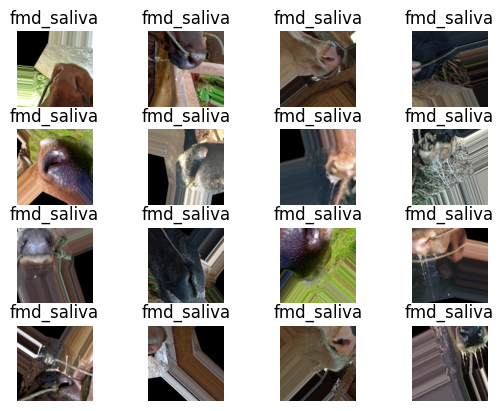

In [16]:
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
  plt.imshow(images[i])
  plt.title(f'{labels[np.argmax(titles[i],axis=0)]}')
  plt.axis("off")

In [17]:
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  # Instantiate the callback class
  # callbacks = myCallback()

  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
     
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
   
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
    
    
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(), 
      # 512 neuron hidden layer
      tf.keras.layers.Dense(256, activation='relu'), 
      tf.keras.layers.Dense(512, activation='relu'), 
      tf.keras.layers.Dropout(0.5),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  from tensorflow.keras.optimizers import Adam

  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
     
  ### END CODE HERE

  return model


In [18]:
#from keras.api._v2.keras import callbacks
# Get the untrained model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
#ga perlu di run
initial_learning_rate = 0.01
epochs = 200
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [19]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=validation_generator
                    )


Epoch 1/200
17/17 [==============================] - 22s 595ms/step - loss: 0.6937 - accuracy: 0.4760 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 2/200
17/17 [==============================] - 9s 537ms/step - loss: 0.6850 - accuracy: 0.5329 - val_loss: 0.6790 - val_accuracy: 0.5714
Epoch 3/200
17/17 [==============================] - 8s 454ms/step - loss: 0.6852 - accuracy: 0.6287 - val_loss: 0.6712 - val_accuracy: 0.6548
Epoch 4/200
17/17 [==============================] - 8s 451ms/step - loss: 0.6716 - accuracy: 0.6048 - val_loss: 0.6514 - val_accuracy: 0.7024
Epoch 5/200
17/17 [==============================] - 9s 533ms/step - loss: 0.6510 - accuracy: 0.6737 - val_loss: 0.6152 - val_accuracy: 0.6905
Epoch 6/200
17/17 [==============================] - 8s 488ms/step - loss: 0.5995 - accuracy: 0.7395 - val_loss: 0.6106 - val_accuracy: 0.7024
Epoch 7/200
17/17 [==============================] - 9s 502ms/step - loss: 0.5626 - accuracy: 0.7066 - val_loss: 0.5431 - val_accuracy: 0.726

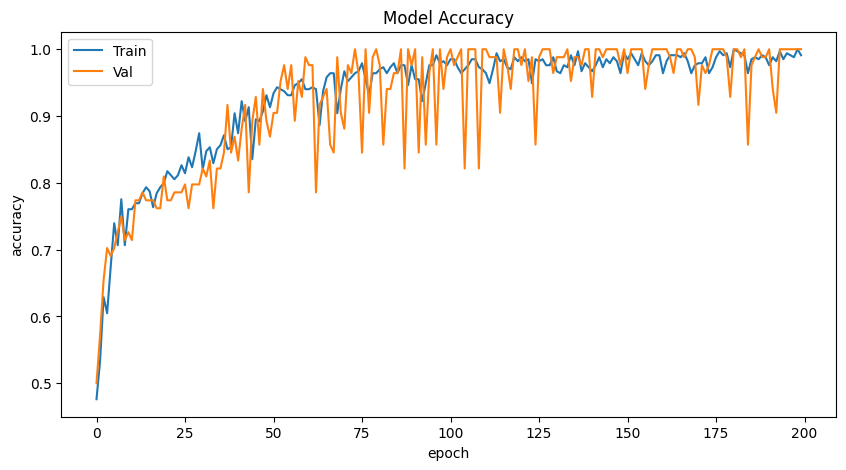

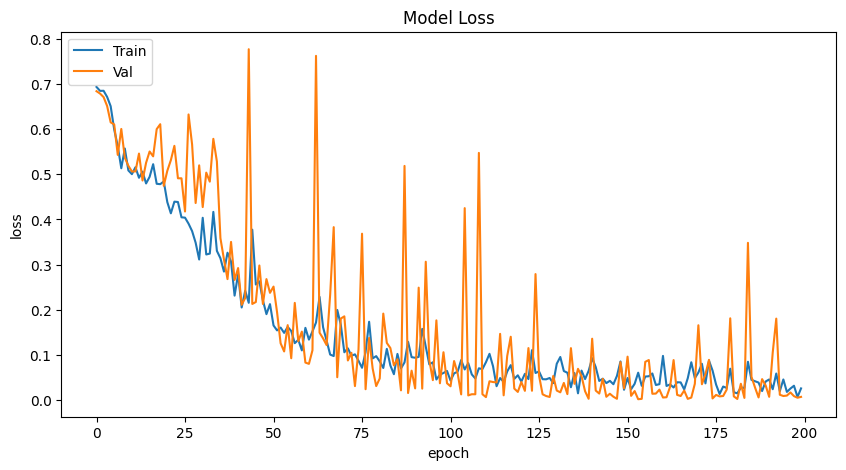

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [67]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  percent = "{:.2f}".format(100 - classes[0][0]*100)
  print("Health Percentage: %.2f%%" % (classes[0]*100))

Saving air_liur_13.jpeg to air_liur_13.jpeg
1/1 [==============================] - 0s 20ms/step
[0.01564733]
Health Percentage: 1.56%


In [68]:
if classes[0]>0.5:
  print("Sapi Anda tidak mengalami gejala PMK.")
else:
  print("Sapi anda memiliki kemungkinan mengalami PMK berdasarkan gejala pada air liur sebesar " + percent + "%.")

Sapi anda memiliki kemungkinan mengalami PMK berdasarkan gejala pada air liur sebesar 98.44%.


In [70]:
model.save("model_saliva(1).h5")

In [38]:
loaded_model = tf.keras.models.load_model('model_saliva.h5')